# A Gaussian Integral

Using Montecarlo integration to check that

$$
    \int_0^\infty x^3 \exp{\left( - \frac{x^2}{2 \sigma^2} \right)} dx = 2 \sigma^4
$$

 - Does the result converge with the number of samples? And how does the error go down?
 - Do it many times. For a given $N$, how are the result distributed? We'll talk about model fitting at lenght later on, but for now try to fit it by hand with a parametrized model. (If $N$ is large enough you should get something that looks very accurate! And if $N$ is small?)
 - How does the distribution change if $N$ increases?

(Hint: think about sample mean and sample variance)


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import halfnorm
from scipy.stats import norm, t, skewnorm
from scipy.optimize import curve_fit
from tqdm import tqdm

## Function and Montecarlo definition

In [4]:
def fun(x):
    return x**3

def MonteCarlo(sigma, N):
    
    # I extract a number from a half Gaussian and put into 'fun()' to have f_i
    x_i = halfnorm.rvs(0, sigma, N)
    f_i = fun(x_i)
    
    return np.sqrt(np.pi * sigma**2 / 2) * 1 / N * np.sum(f_i)

Now I try to compute the integral by doing $n=1000$ simulations with $N=10000$ samples.

In [5]:
n = 1000    # Number of the simulations
N = 10000   # number of samples

sigma = 2 
real_solution = 2 * sigma**4

In [6]:
results = []

for i in range(n):
    results.append(MonteCarlo(sigma, N))

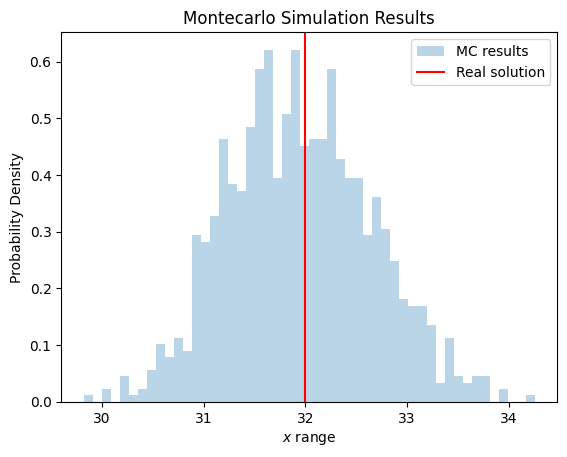

In [48]:
plt.hist(results, bins=50, alpha=0.3, density=True, label='MC results')
plt.axvline(x = real_solution, color='red', linewidth=1.5, label='Real solution')
plt.xlabel('$x$ range')
plt.ylabel('Probability Density')
plt.title('Montecarlo Simulation Results')
plt.legend()
plt.show()

## Try with small $N$
How do the results changes if my number of samples $N$ is small? I now try to do $n=1000$ simulation with $N=5$ samples.

In [16]:
N_small = 5

results_smallN = []

for i in range(n):
    results_smallN.append(MonteCarlo(sigma, N_small))

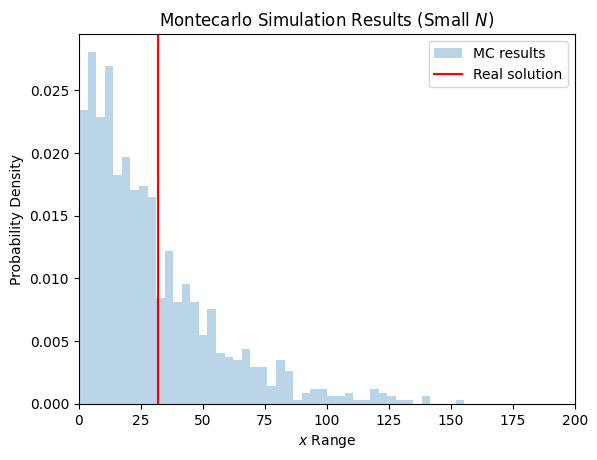

In [47]:
plt.hist(results_smallN, bins=100, density=True, alpha=0.3, label='MC results')
plt.axvline(x = real_solution, color='red', linewidth=1.5, label='Real solution')
plt.xlabel('$x$ Range')
plt.ylabel('Probability Density')
plt.title('Montecarlo Simulation Results (Small $N$)')
plt.xlim(0, 200)
plt.legend()
plt.show()

## Try with different N
Let's see how the results of the simulation change if we increase the number of samples? Do they converge to the expected value?

In [31]:
N_samples = [5, 200, 1000, 5000, 10000]

results_ns = {}

for ns in N_samples:
    results_ns[f'N_s = {ns}'] = []
    
    for i in range(0, n):
        results_ns[f'N_s = {ns}'].append(MonteCarlo(sigma, ns))


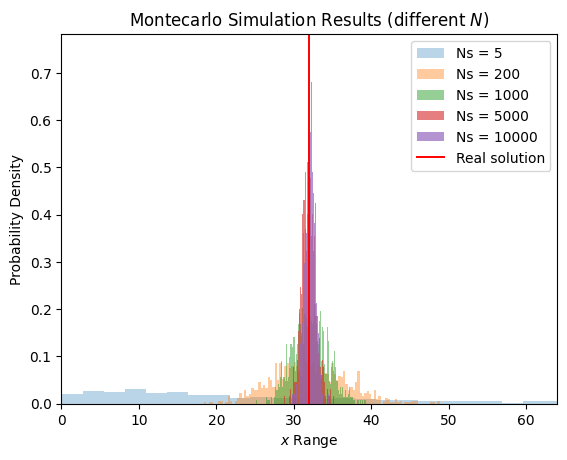

In [49]:
plt.hist(results_ns[f'N_s = 5'],     100, histtype='barstacked', density=True, alpha=0.3, edgecolor=None, label=f'Ns = 5')
plt.hist(results_ns[f'N_s = 200'],   100, histtype='barstacked', density=True, alpha=0.4, edgecolor=None, label=f'Ns = 200')
plt.hist(results_ns[f'N_s = 1000'],  100, histtype='barstacked', density=True, alpha=0.5, edgecolor=None, label=f'Ns = 1000')
plt.hist(results_ns[f'N_s = 5000'],  100, histtype='barstacked', density=True, alpha=0.6, edgecolor=None, label=f'Ns = 5000')
plt.hist(results_ns[f'N_s = 10000'], 100, histtype='barstacked', density=True, alpha=0.7, edgecolor=None, label=f'Ns = 10000')

plt.axvline(x = real_solution, color='red', linewidth=1.4, label='Real solution')
plt.xlabel('$x$ Range')
plt.ylabel('Probability Density')
plt.title('Montecarlo Simulation Results (different $N$)')
plt.xlim(0, 64)
plt.legend()

As $N$ increases, the function appears to narrow and sharpen gradually. Moreover, the peak becomes more centered towards the "ideal" solution, indicating that increasing the number of samples for integration yields a more accurate estimate of the result.

## Errors
How do the errors scale with the number of samples? 

In [52]:
N_samples2 = np.logspace(0, 6, 100, dtype=int) 

In [58]:
results1 = [MonteCarlo(sigma, Ns) for Ns in tqdm(N_samples2)]
errors1  = [abs(result - real_solution) for result in tqdm(results1)]


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 462.08it/s]

100%|████████████████████████████████████| 100/100 [00:00<00:00, 1471685.61it/s]


Text(0, 0.5, '$\\sigma_N$')

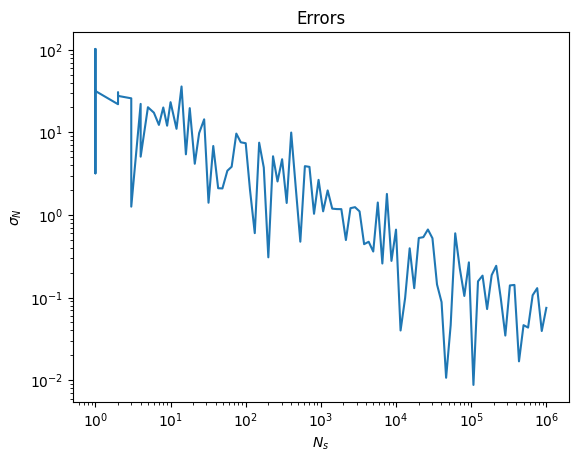

In [67]:
plt.loglog(N_samples2, errors1)
plt.title('Errors')
plt.xlabel('$N_s$')
plt.ylabel('$\sigma_N$')

I make the hypothesis that the error goes as $\frac{I}{\sqrt{N_s}}$ where $N_s$ is the number of samples and $I$ is the $\textit{ideal solution}$.

In [64]:
error_hyp = real_solution / np.sqrt(N_samples2)

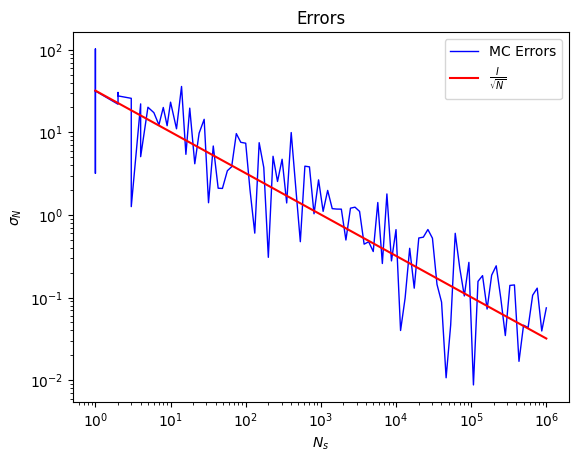

In [72]:
plt.loglog(N_samples2, errors1, color='blue', linewidth=1.0, label='MC Errors')
plt.loglog(N_samples2, error_hyp, color='red', linewidth=1.5, label=r'$\frac{I}{\sqrt{N}}$')
plt.title('Errors')
plt.xlabel('$N_s$')
plt.ylabel('$\sigma_N$')
plt.legend()

## Focus on big $N$
I can make the hypothesis that, for a high number of samples (say $N = 10000$) the distribution of the results can be fitted by a Gaussian distribution, centered in the real value of the integral.
I have to do an estimation of the sigma of the Gaussian distribution. Since we expect to find the $68.3 \%$ of the results inside $1\sigma$, we can give an estimate of $\sigma$ by using the percentiles ($84.15$, $15.85$).

In [93]:
# Error estimate
my_sigma = [np.percentile(results_ns['N_s = 10000'], 84.15) - np.percentile(results_ns['N_s = 10000'], 15.85)][0]/2

print(f'sigma = {my_sigma}')

sigma = 0.6911756173416315


In [101]:
x = np.linspace(real_solution-15, real_solution+15, 10000)
my_gaussian = norm.pdf(x, loc=real_solution, scale=my_sigma)

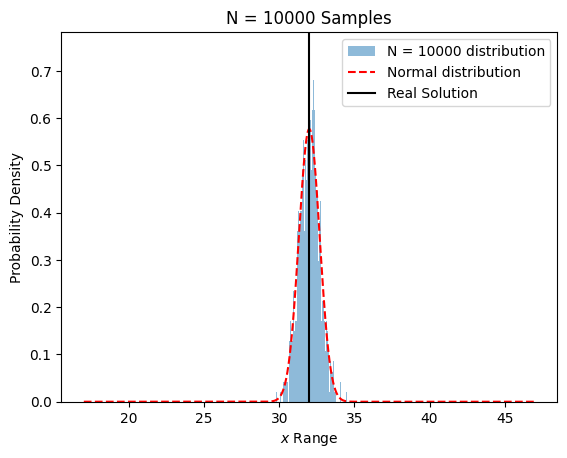

In [103]:
plt.hist(results_ns['N_s = 10000'], 100, alpha=0.5, density=True, label='N = 10000 distribution')
plt.plot(x, my_gaussian, color='red', linewidth=1.5, ls='--', label='Normal distribution')
plt.axvline(x=real_solution, color='black', label='Real Solution')
plt.xlabel('$x$ Range')
plt.ylabel('Probability Density')
plt.title('N = 10000 Samples')
plt.legend()

The distribution is not Gaussian for small $N$, while it approaches a Gaussian distribution in the limit for large $N$.